##High-Noise

In [6]:
import pandas as pd
import glob
import os

# ==============================
# 1. Set paths and configs
# ==============================

configs = ["BASELINE", "NOISE_1", "NOISE_2", "NOISE_3", "NOISE_4", "NOISE_5","NOISE_6","NOISE_7",
           "TX_1", "TX_2", "TX_3", "TX_4", "TX_5","TX_6","TX_7",
           "SENS_1", "SENS_2", "SENS_3", "SENS_4", "SENS_5","SENS_6","SENS_7"]

base_dir = "/content"  # Folder containing all CSVs

# Dictionary to store all CSVs per config
data = {}

for cfg in configs:
    data[cfg] = {}

    # Pattern match files by config prefix
    udp_files = glob.glob(os.path.join(base_dir, f"{cfg}_udpPacketTransmissionInfo.csv"))
    dataerror_files = glob.glob(os.path.join(base_dir, f"{cfg}_DataErrorRate.csv"))
    headererror_files = glob.glob(os.path.join(base_dir, f"{cfg}_HeaderErrorRate.csv"))
    cw_files = glob.glob(os.path.join(base_dir, f"{cfg}_cwUsed.csv"))

    # Load files if they exist
    data[cfg]["udp"] = pd.read_csv(udp_files[0]) if udp_files else pd.DataFrame()
    data[cfg]["dataerror"] = pd.read_csv(dataerror_files[0]) if dataerror_files else pd.DataFrame()
    data[cfg]["headererror"] = pd.read_csv(headererror_files[0]) if headererror_files else pd.DataFrame()
    data[cfg]["cwUsed"] = pd.read_csv(cw_files[0]) if cw_files else pd.DataFrame()

print("CSV files loaded for all configs. Ready for metric calculations.")


CSV files loaded for all configs. Ready for metric calculations.


In [7]:
# Compute End-to-End Delay statistics per config
delay_stats = {}

for cfg in configs:
    df = data[cfg]["udp"]
    if not df.empty:
        delays = df["Delay"]  # seconds
        delay_stats[cfg] = {
            "min": delays.min(),
            "max": delays.max(),
            "avg": delays.mean()
        }
    else:
        delay_stats[cfg] = {"min": None, "max": None, "avg": None}

pd.DataFrame(delay_stats).T


,min,max,avg
BASELINE,0.000037,1.027986,0.012481
NOISE_1,0.000037,1.027986,0.012481
NOISE_2,0.000037,1.027986,0.012481
NOISE_3,0.000037,1.020242,0.012392
NOISE_4,0.000037,0.000099,0.000050
NOISE_5,0.000037,0.000099,0.000050
NOISE_6,0.000037,0.000099,0.000050
NOISE_7,0.000037,0.000099,0.000050
TX_1,0.000037,1.027986,0.012481
TX_2,0.000037,1.027986,0.012481


In [9]:
pdr_stats = {}

for cfg in configs:
    df = data[cfg]["udp"]
    if not df.empty:
        # Count unique packet IDs received
        received_packets = df["Packet ID"].nunique()
        # Estimate total packets sent from senders
        senders = df["Sender"].nunique()
        sim_time = df["Simulation Time"].max()
        send_interval = df["Simulation Time"].diff().median()  # approximate send interval
        total_sent = senders * sim_time / send_interval
        pdr = received_packets / total_sent
        pdr_stats[cfg] = pdr
    else:
        pdr_stats[cfg] = None

pd.Series(pdr_stats, name="PDR")


,PDR
BASELINE,0.129673
NOISE_1,0.129673
NOISE_2,0.129673
NOISE_3,0.129678
NOISE_4,0.001328
NOISE_5,0.001328
NOISE_6,0.001328
NOISE_7,0.001328
TX_1,0.129673
TX_2,0.129673


In [10]:
throughput_stats = {}

for cfg in configs:
    df = data[cfg]["udp"]
    if not df.empty:
        total_bytes = df["Packet ID"].count() * 100  # message length = 100B
        sim_time = df["Simulation Time"].max()
        throughput_stats[cfg] = total_bytes / sim_time
    else:
        throughput_stats[cfg] = None

pd.Series(throughput_stats, name="Throughput (B/s)")


,Throughput (B/s)
BASELINE,59977.808991
NOISE_1,59977.808991
NOISE_2,59977.808991
NOISE_3,59980.159347
NOISE_4,29999.952236
NOISE_5,29999.952236
NOISE_6,29999.952236
NOISE_7,29999.952236
TX_1,59977.808991
TX_2,59977.808991


In [11]:
ber_stats = {}

for cfg in configs:
    df_data = data[cfg]["dataerror"]
    df_hdr = data[cfg]["headererror"]

    # Skip if either CSV is empty
    if df_data.empty or df_hdr.empty:
        ber_stats[cfg] = None
        continue

    # Normalize column names (strip spaces and lowercase)
    df_data.columns = df_data.columns.str.strip().str.lower()
    df_hdr.columns = df_hdr.columns.str.strip().str.lower()

    # Compute BER for entire packet
    total_bits = df_data["data length"].sum() + df_hdr["header length"].sum()
    total_errors = (df_data["error rate"] * df_data["data length"]).sum() + \
                   (df_hdr["error rate"] * df_hdr["header length"]).sum()
    ber_stats[cfg] = total_errors / total_bits

# Convert to pandas Series for display
pd.Series(ber_stats, name="BER")


,BER
BASELINE,0.056785
NOISE_1,0.056785
NOISE_2,0.056789
NOISE_3,0.056032
NOISE_4,NaN
NOISE_5,NaN
NOISE_6,NaN
NOISE_7,NaN
TX_1,0.056785
TX_2,0.056786


In [12]:
ber_stats = {}
snir_stats = {}

for cfg in configs:
    df_data = data[cfg]["dataerror"]
    df_hdr = data[cfg]["headererror"]

    # Skip if either CSV is empty
    if df_data.empty or df_hdr.empty:
        ber_stats[cfg] = None
        snir_stats[cfg] = None
        continue

    # Normalize column names: strip spaces and lowercase
    df_data.columns = df_data.columns.str.strip().str.lower()
    df_hdr.columns = df_hdr.columns.str.strip().str.lower()

    # Compute BER for entire packet
    total_bits = df_data["data length"].sum() + df_hdr["header length"].sum()
    total_errors = (df_data["error rate"] * df_data["data length"]).sum() + \
                   (df_hdr["error rate"] * df_hdr["header length"]).sum()
    ber_stats[cfg] = total_errors / total_bits

    # Compute average SNIR (simple mean over both CSVs)
    snir_values = pd.concat([df_data["snir"], df_hdr["snir"]])
    snir_stats[cfg] = snir_values.mean()

# Display as pandas Series
print("BER:")
display(pd.Series(ber_stats, name="BER"))
print("Average SNIR:")
display(pd.Series(snir_stats, name="SNIR"))


BER:


,BER
BASELINE,0.056785
NOISE_1,0.056785
NOISE_2,0.056789
NOISE_3,0.056032
NOISE_4,NaN
NOISE_5,NaN
NOISE_6,NaN
NOISE_7,NaN
TX_1,0.056785
TX_2,0.056786


Average SNIR:


,SNIR
BASELINE,7646.258511
NOISE_1,4824.478159
NOISE_2,764.672267
NOISE_3,76.549895
NOISE_4,NaN
NOISE_5,NaN
NOISE_6,NaN
NOISE_7,NaN
TX_1,3823.155609
TX_2,1911.601690


In [28]:
# Convert dictionaries / series to DataFrames
delay_df = pd.DataFrame(delay_stats).T  # min, max, avg
pdr_df = pd.Series(pdr_stats, name="PDR").to_frame()
throughput_df = pd.Series(throughput_stats, name="Throughput (B/s)").to_frame()
ber_df = pd.Series(ber_stats, name="BER").to_frame()
snir_df = pd.Series(snir_stats, name="SNIR").to_frame()

# Combine all metrics into one DataFrame
summary_df = pd.concat([delay_df, pdr_df, throughput_df, ber_df, snir_df], axis=1)

# Optional: reset index to have config as a column
summary_df = summary_df.reset_index().rename(columns={"index": "Config"})

# Display combined summary
summary_df


,Config,min,max,avg,PDR,Throughput (B/s),BER,SNIR
0,BASELINE,0.000037,1.027986,0.012481,0.129673,59977.808991,0.056785,7646.258511
1,NOISE_1,0.000037,1.027986,0.012481,0.129673,59977.808991,0.056785,4824.478159
2,NOISE_2,0.000037,1.027986,0.012481,0.129673,59977.808991,0.056789,764.672267
3,NOISE_3,0.000037,1.020242,0.012392,0.129678,59980.159347,0.056032,76.549895
4,NOISE_4,0.000037,0.000099,0.000050,0.001328,29999.952236,NaN,NaN
5,NOISE_5,0.000037,0.000099,0.000050,0.001328,29999.952236,NaN,NaN
6,NOISE_6,0.000037,0.000099,0.000050,0.001328,29999.952236,NaN,NaN
7,NOISE_7,0.000037,0.000099,0.000050,0.001328,29999.952236,NaN,NaN
8,TX_1,0.000037,1.027986,0.012481,0.129673,59977.808991,0.056785,3823.155609
9,TX_2,0.000037,1.027986,0.012481,0.129673,59977.808991,0.056786,1911.601690


In [26]:
# for cfg in configs:
#     df = data[cfg]["udp"]
#     print(cfg)
#     print(df.head())
#     print(df.columns)
#     if not df.empty:
#         df["Delay"] = pd.to_numeric(df["Delay"], errors='coerce')
#         print("min:", df["Delay"].min(), "max:", df["Delay"].max(), "mean:", df["Delay"].mean())


Saved Delay_avg_Noise_vs_Baseline.png


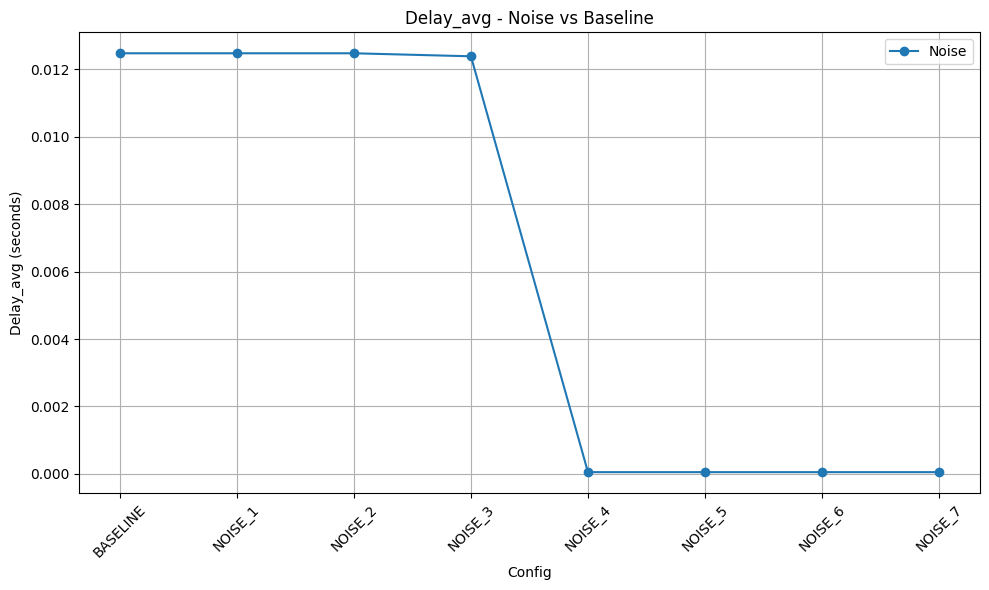

Saved Delay_avg_TX_vs_Baseline.png


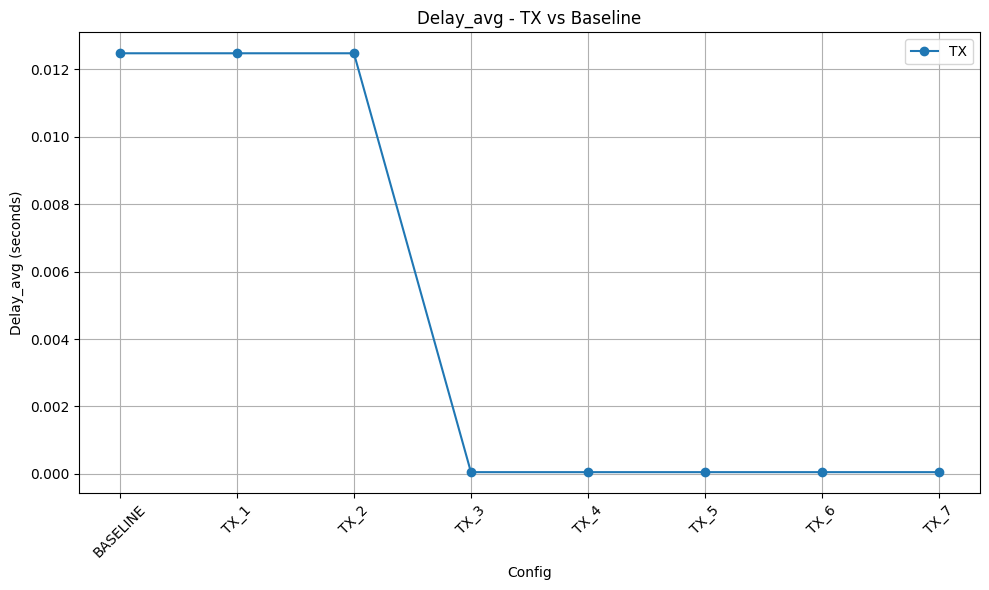

Saved Delay_avg_Sensitivity_vs_Baseline.png


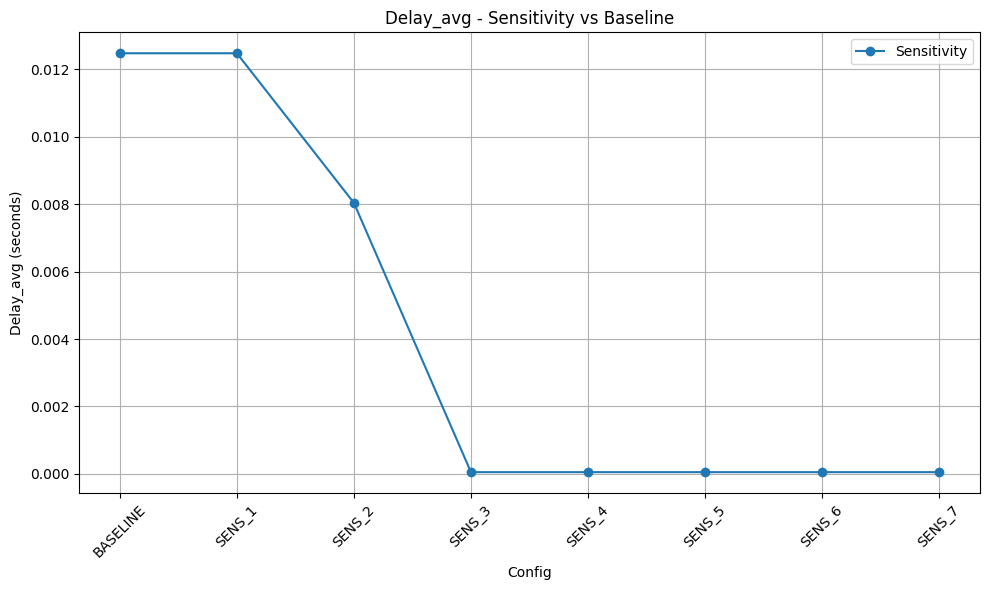

Saved PDR_Noise_vs_Baseline.png


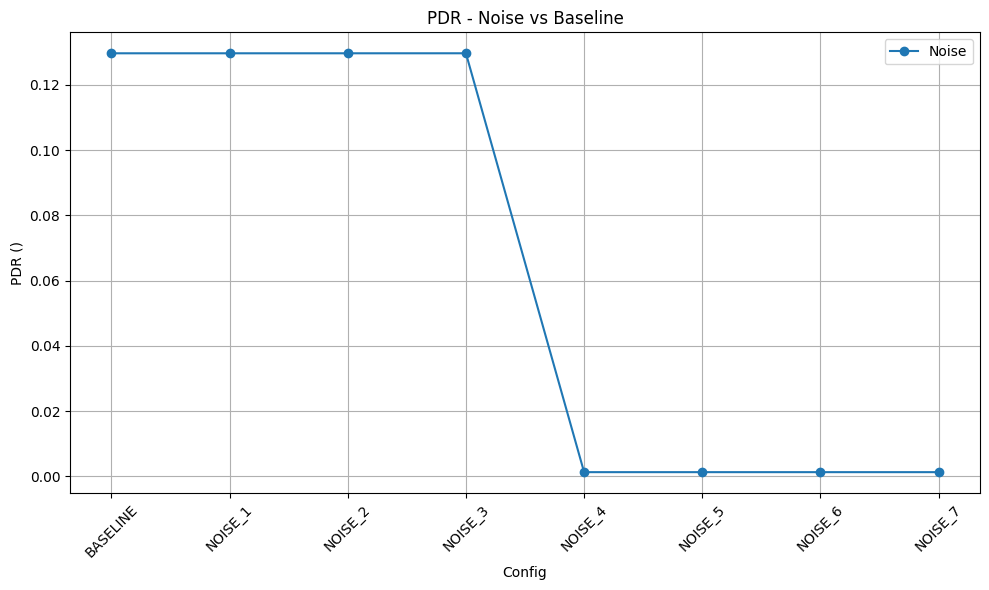

Saved PDR_TX_vs_Baseline.png


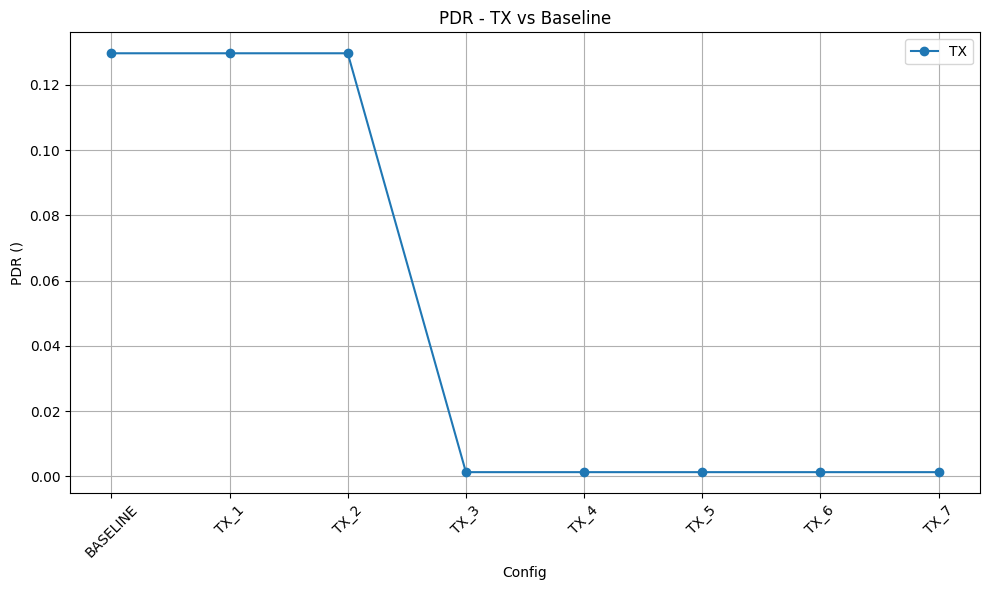

Saved PDR_Sensitivity_vs_Baseline.png


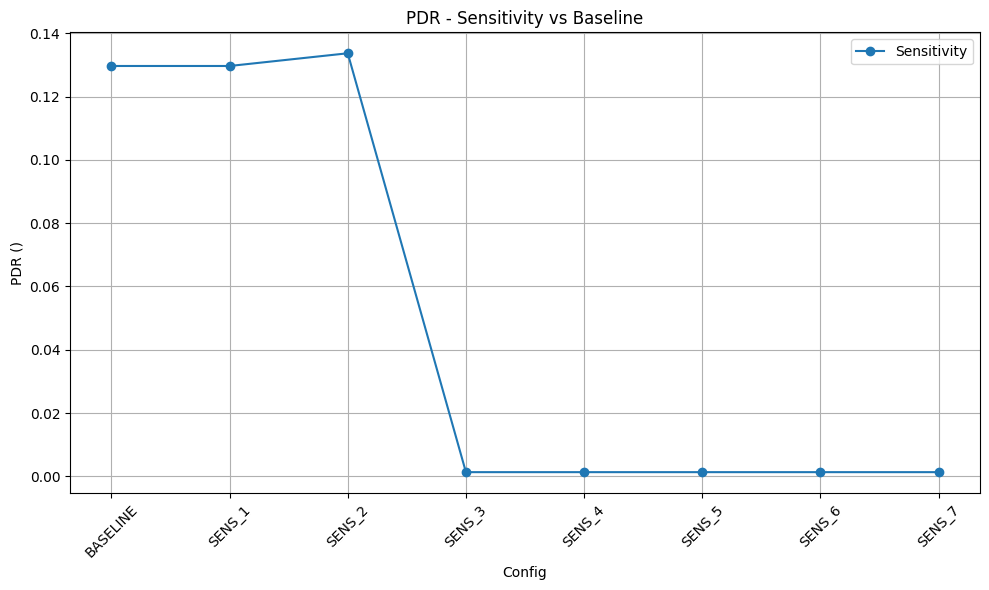

Saved Throughput_Noise_vs_Baseline.png


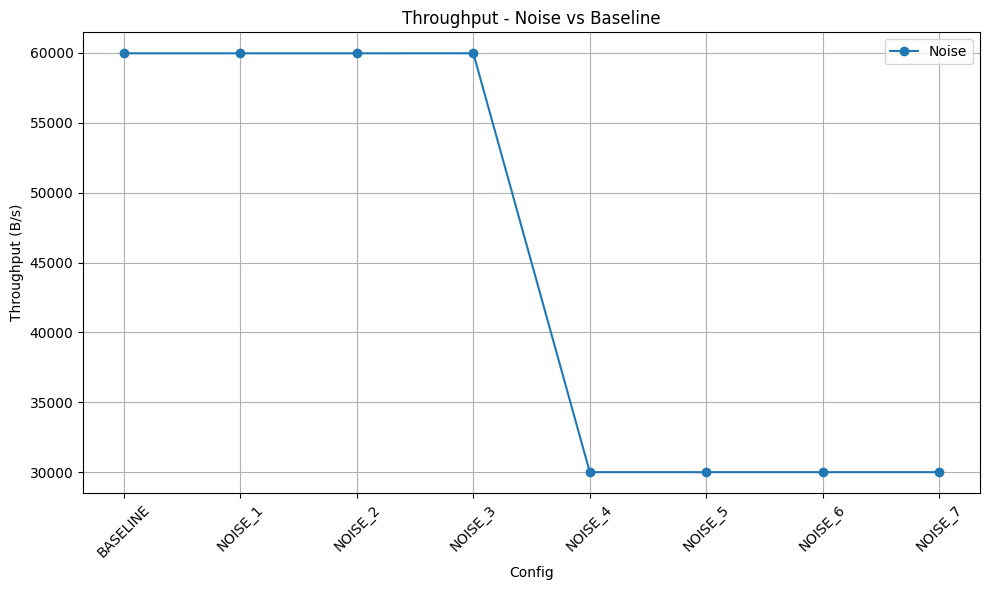

Saved Throughput_TX_vs_Baseline.png


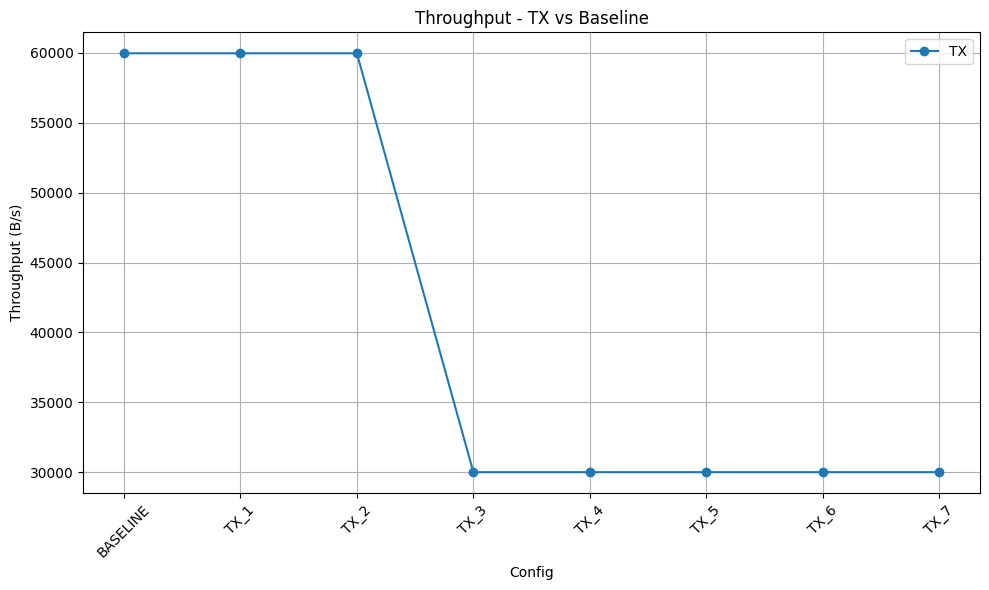

Saved Throughput_Sensitivity_vs_Baseline.png


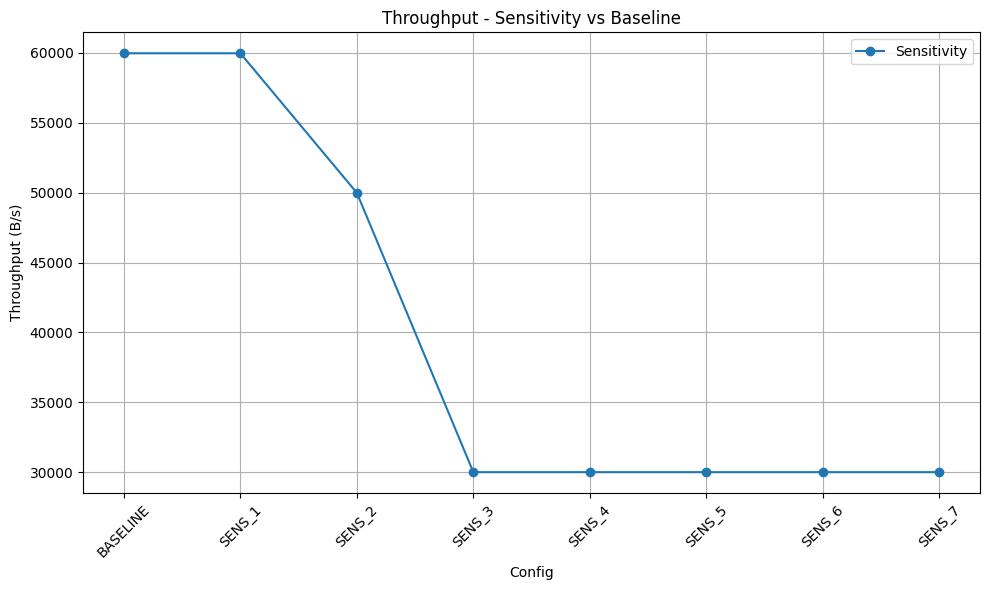

Saved BER_Noise_vs_Baseline.png


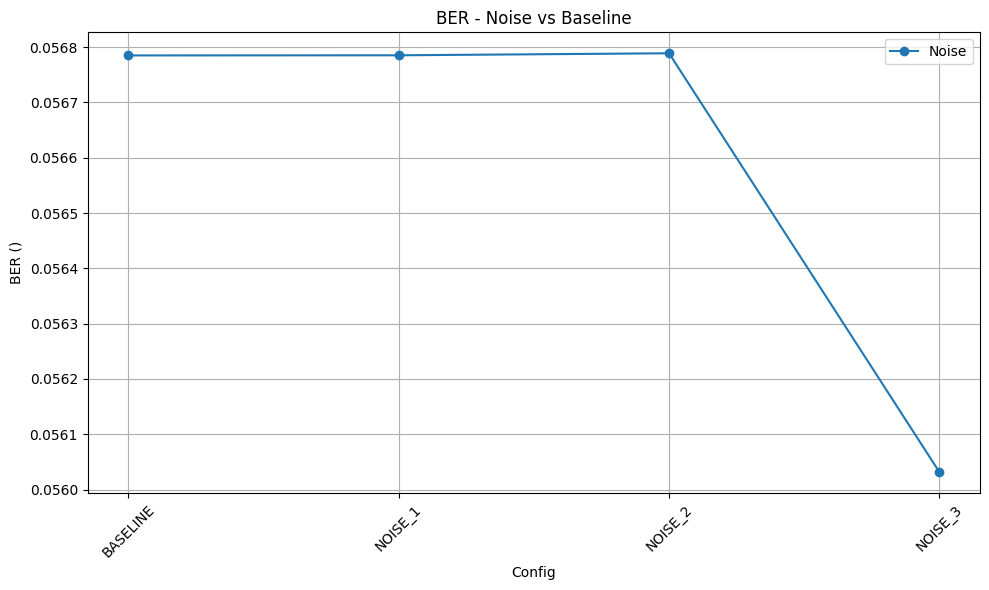

Saved BER_TX_vs_Baseline.png


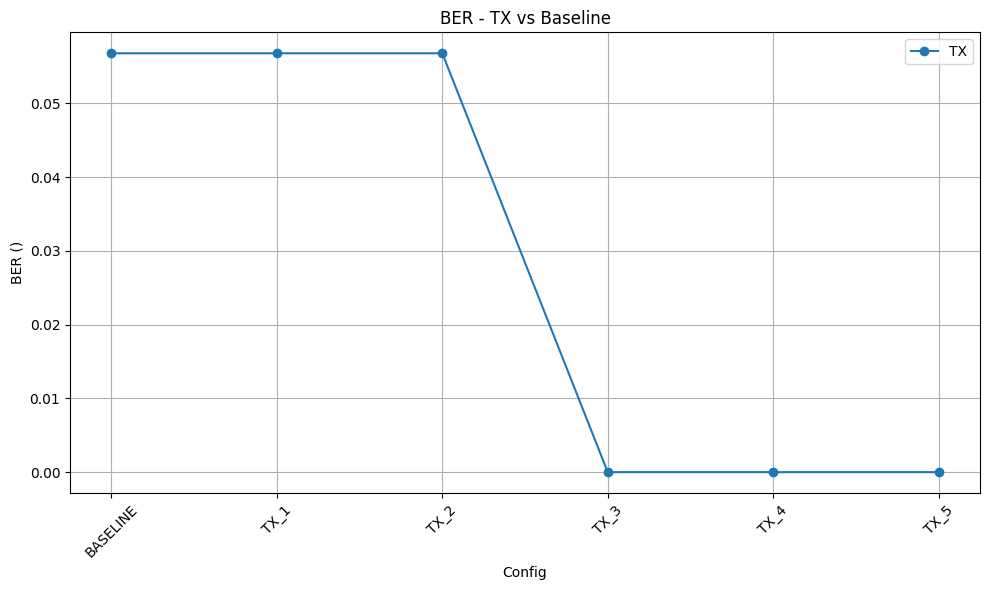

Saved BER_Sensitivity_vs_Baseline.png


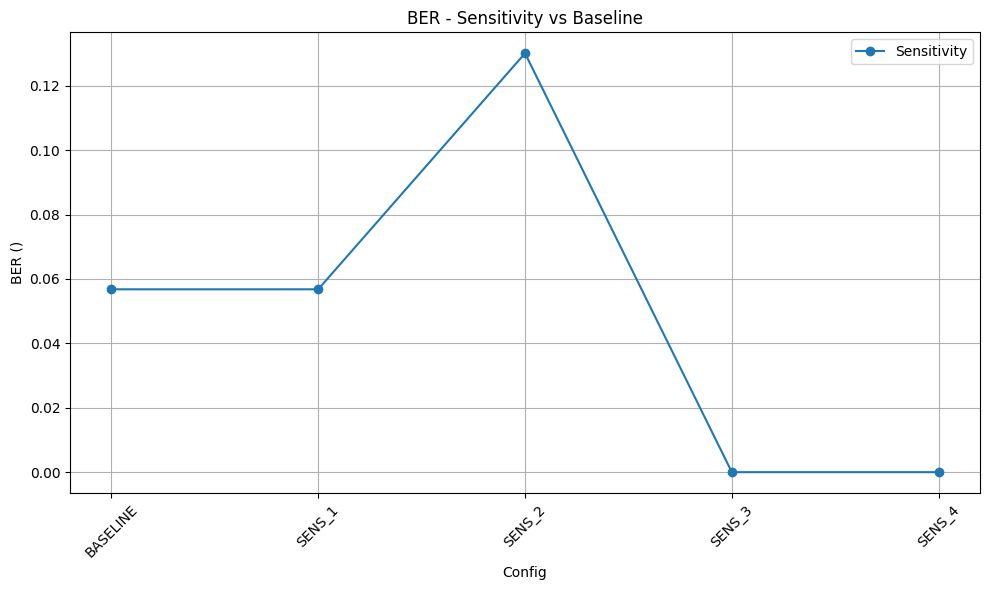

Saved SNIR_Noise_vs_Baseline.png


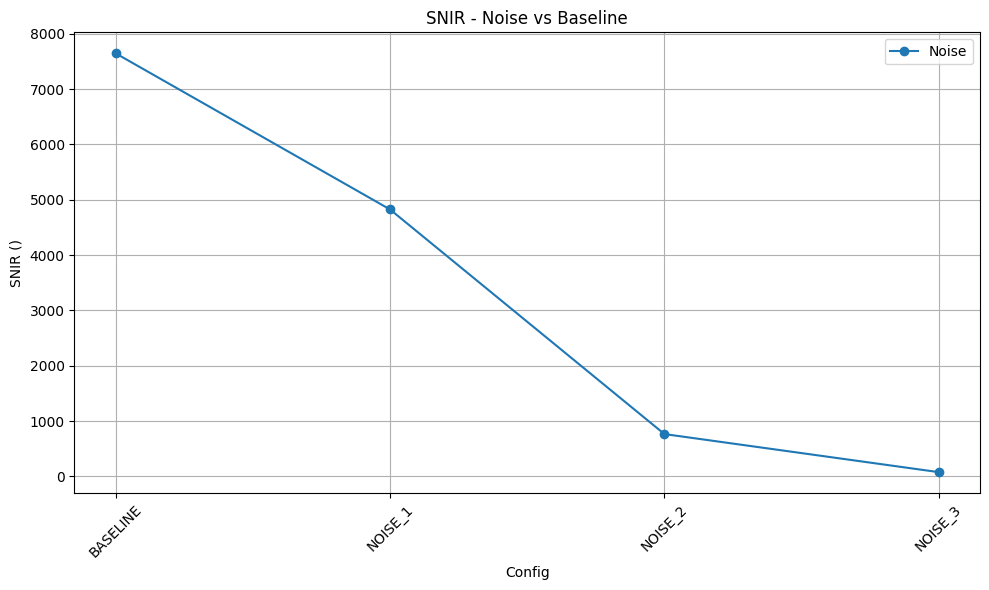

Saved SNIR_TX_vs_Baseline.png


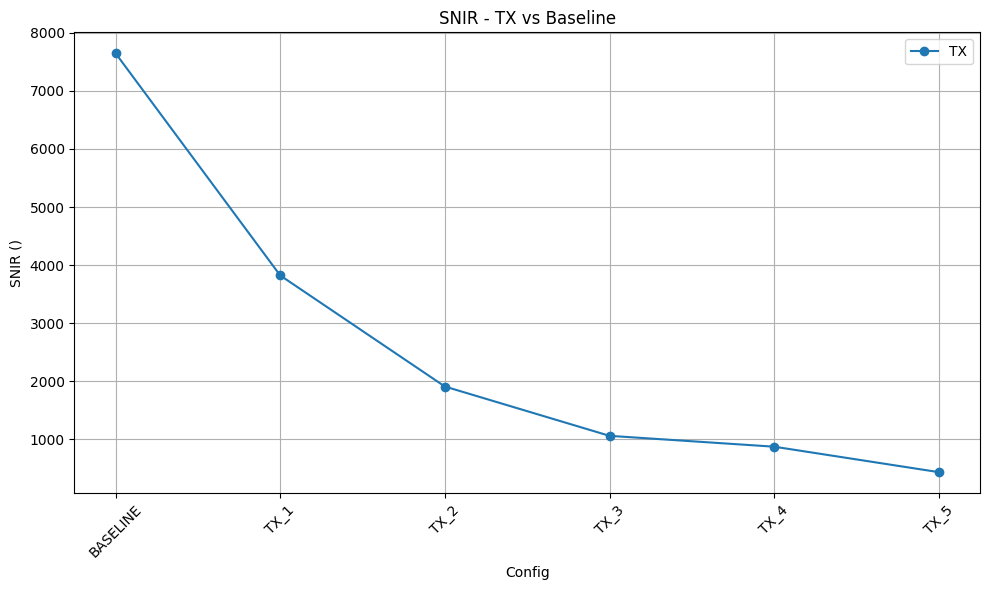

Saved SNIR_Sensitivity_vs_Baseline.png


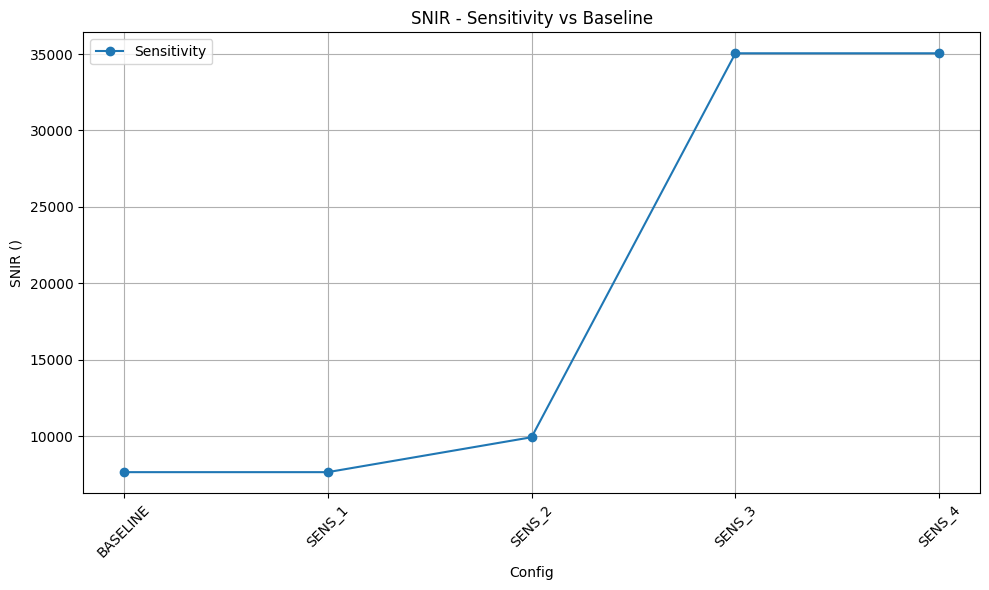

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert your stats dicts to DataFrames for easier plotting
metrics = {
    "Delay_avg": {"data": {cfg: delay_stats[cfg]["avg"] for cfg in configs}, "unit": "seconds"},
    "PDR": {"data": pdr_stats, "unit": ""}, # PDR is unitless
    "Throughput": {"data": throughput_stats, "unit": "B/s"},
    "BER": {"data": ber_stats, "unit": ""}, # BER is unitless
    "SNIR": {"data": snir_stats, "unit": ""} # SNIR is often in dB, but here seems linear
}

metrics_df = pd.DataFrame({metric: data["data"] for metric, data in metrics.items()})

# Define groups
noise = ["NOISE_1","NOISE_2","NOISE_3","NOISE_4","NOISE_5","NOISE_6","NOISE_7"]
tx = ["TX_1","TX_2","TX_3","TX_4","TX_5","TX_6","TX_7"]
sens = ["SENS_1","SENS_2","SENS_3","SENS_4","SENS_5","SENS_6","SENS_7"]
baseline = "BASELINE"

groups = {"Noise": noise, "TX": tx, "Sensitivity": sens}

# Plot function
def plot_metric(metric_name, unit):
    for group_name, cfgs in groups.items():
        plt.figure(figsize=(10,6))
        y = [metrics_df.loc[baseline, metric_name]]  # baseline first
        y += metrics_df.loc[cfgs, metric_name].tolist()
        x = [baseline] + cfgs
        plt.plot(x, y, marker='o', label=group_name)
        plt.title(f"{metric_name} - {group_name} vs Baseline")
        plt.xlabel("Config")
        plt.ylabel(f"{metric_name} ({unit})") # Added unit to ylabel
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()

        # Save the figure as PNG
        filename = f"{metric_name}_{group_name}_vs_Baseline.png" # Changed extension to .png
        plt.tight_layout() # Adjust layout to prevent labels overlapping
        plt.savefig(filename)
        print(f"Saved {filename}")

        plt.show()


# Plot all metrics
for metric, data in metrics.items():
    plot_metric(metric, data["unit"]) # Pass unit to plot_metric

In [27]:
import pandas as pd
import glob
import os

# ==============================
# 1. Set paths and configs
# ==============================
configs = ["BASELINE", "NOISE_1", "NOISE_2", "NOISE_3", "NOISE_4", "NOISE_5","NOISE_6","NOISE_7",
           "TX_1", "TX_2", "TX_3", "TX_4", "TX_5","TX_6","TX_7",
           "SENS_1", "SENS_2", "SENS_3", "SENS_4", "SENS_5","SENS_6","SENS_7"]

base_dir = "/content"  # Folder containing all CSVs

# Dictionary to store all CSVs per config
data = {}

for cfg in configs:
    data[cfg] = {}

    # Pattern match files by config prefix
    udp_files = glob.glob(os.path.join(base_dir, f"{cfg}_udpPacketTransmissionInfo.csv"))
    dataerror_files = glob.glob(os.path.join(base_dir, f"{cfg}_DataErrorRate.csv"))
    headererror_files = glob.glob(os.path.join(base_dir, f"{cfg}_HeaderErrorRate.csv"))
    cw_files = glob.glob(os.path.join(base_dir, f"{cfg}_cwUsed.csv"))

    # Load files if they exist
    data[cfg]["udp"] = pd.read_csv(udp_files[0]) if udp_files else pd.DataFrame()
    data[cfg]["dataerror"] = pd.read_csv(dataerror_files[0]) if dataerror_files else pd.DataFrame()
    data[cfg]["headererror"] = pd.read_csv(headererror_files[0]) if headererror_files else pd.DataFrame()
    data[cfg]["cwUsed"] = pd.read_csv(cw_files[0]) if cw_files else pd.DataFrame()

print("CSV files loaded for all configs.")

# ==============================
# 2. Compute metrics
# ==============================
metrics = []

for cfg in configs:
    row = {"Config": cfg}

    # --- End-to-End Delay ---
    df_udp = data[cfg]["udp"]
    if not df_udp.empty:
        delays = df_udp["Delay"]
        row.update({"min": delays.min(), "max": delays.max(), "avg": delays.mean()})
    else:
        row.update({"min": None, "max": None, "avg": None})

    # --- PDR ---
    if not df_udp.empty:
        received_packets = df_udp["Packet ID"].nunique()
        # Estimate total packets sent from senders
        senders = df_udp["Sender"].nunique()
        sim_time = df_udp["Simulation Time"].max()
        send_interval = df_udp["Simulation Time"].diff().median() or 0.01  # fallback if median=NaN
        total_sent = senders * sim_time / send_interval
        row["PDR"] = received_packets / total_sent if total_sent > 0 else None
    else:
        row["PDR"] = None

    # --- Throughput ---
    if not df_udp.empty:
        packet_size_bytes = 100  # adjust if actual size is different
        total_bytes = df_udp["Packet ID"].count() * packet_size_bytes
        row["Throughput (B/s)"] = total_bytes / sim_time if sim_time > 0 else None
    else:
        row["Throughput (B/s)"] = None

    # --- BER and SNIR ---
    df_data = data[cfg]["dataerror"]
    df_hdr = data[cfg]["headererror"]

    if df_data.empty or df_hdr.empty:
        row["BER"] = None
        row["SNIR"] = None
    else:
        # Normalize column names
        df_data.columns = df_data.columns.str.strip().str.lower()
        df_hdr.columns = df_hdr.columns.str.strip().str.lower()

        # BER calculation weighted by bits
        total_bits = df_data["data length"].sum() + df_hdr["header length"].sum()
        total_errors = (df_data["error rate"] * df_data["data length"]).sum() + \
                       (df_hdr["error rate"] * df_hdr["header length"]).sum()
        row["BER"] = total_errors / total_bits if total_bits > 0 else None

        # Weighted SNIR (per bit)
        weighted_snir = ((df_data["snir"] * df_data["data length"]).sum() +
                         (df_hdr["snir"] * df_hdr["header length"]).sum()) / total_bits if total_bits > 0 else None
        row["SNIR"] = weighted_snir

    metrics.append(row)

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics)
df_metrics


CSV files loaded for all configs.


,Config,min,max,avg,PDR,Throughput (B/s),BER,SNIR
0,BASELINE,0.000037,1.027986,0.012481,0.129673,59977.808991,0.056785,10368.270466
1,NOISE_1,0.000037,1.027986,0.012481,0.129673,59977.808991,0.056785,6541.964401
2,NOISE_2,0.000037,1.027986,0.012481,0.129673,59977.808991,0.056789,1036.908544
3,NOISE_3,0.000037,1.020242,0.012392,0.129678,59980.159347,0.056032,103.860151
4,NOISE_4,0.000037,0.000099,0.000050,0.001328,29999.952236,NaN,NaN
5,NOISE_5,0.000037,0.000099,0.000050,0.001328,29999.952236,NaN,NaN
6,NOISE_6,0.000037,0.000099,0.000050,0.001328,29999.952236,NaN,NaN
7,NOISE_7,0.000037,0.000099,0.000050,0.001328,29999.952236,NaN,NaN
8,TX_1,0.000037,1.027986,0.012481,0.129673,59977.808991,0.056785,5184.181502
9,TX_2,0.000037,1.027986,0.012481,0.129673,59977.808991,0.056786,2592.133699


In [19]:
print(data["NOISE_4"]["udp"].head())
print(data["NOISE_4"]["udp"].columns)

   Simulation Time     Sender             Receiver  Packet ID     Delay
0         0.010072   10.0.0.9  10.0.0.5 (sinkNode)        312  0.000072
1         0.010085  10.0.0.13  10.0.0.5 (sinkNode)        316  0.000085
2         0.010099  10.0.0.17  10.0.0.5 (sinkNode)        320  0.000099
3         0.020037   10.0.0.9  10.0.0.5 (sinkNode)        340  0.000037
4         0.020050  10.0.0.13  10.0.0.5 (sinkNode)        344  0.000050
Index(['Simulation Time', 'Sender', 'Receiver', 'Packet ID', 'Delay'], dtype='object')


In [21]:
configs_with_low_delay = ["NOISE_4", "NOISE_5", "NOISE_6", "NOISE_7",
                          "TX_3", "TX_4", "TX_5", "TX_6", "TX_7",
                          "SENS_3", "SENS_4", "SENS_5", "SENS_6", "SENS_7"]

print("Analysis of configurations with low delay:")
for cfg in configs_with_low_delay:
    df = data[cfg]["udp"]
    if not df.empty:
        received_packets = df["Packet ID"].nunique()
        sim_time = df["Simulation Time"].max()
        print(f"Config: {cfg}, Received Packets: {received_packets}, Simulation Time: {sim_time:.4f}")
    else:
        print(f"Config: {cfg}, UDP data is empty.")

print("\nAnalysis of Baseline configuration:")
df_baseline = data["BASELINE"]["udp"]
if not df_baseline.empty:
    received_packets_baseline = df_baseline["Packet ID"].nunique()
    sim_time_baseline = df_baseline["Simulation Time"].max()
    print(f"Config: BASELINE, Received Packets: {received_packets_baseline}, Simulation Time: {sim_time_baseline:.4f}")
else:
    print("Config: BASELINE, UDP data is empty.")

Analysis of configurations with low delay:
Config: NOISE_4, Received Packets: 11997, Simulation Time: 39.9901
Config: NOISE_5, Received Packets: 11997, Simulation Time: 39.9901
Config: NOISE_6, Received Packets: 11997, Simulation Time: 39.9901
Config: NOISE_7, Received Packets: 11997, Simulation Time: 39.9901
Config: TX_3, Received Packets: 11997, Simulation Time: 39.9901
Config: TX_4, Received Packets: 11997, Simulation Time: 39.9901
Config: TX_5, Received Packets: 11997, Simulation Time: 39.9901
Config: TX_6, Received Packets: 11997, Simulation Time: 39.9901
Config: TX_7, Received Packets: 11997, Simulation Time: 39.9901
Config: SENS_3, Received Packets: 11997, Simulation Time: 39.9901
Config: SENS_4, Received Packets: 11997, Simulation Time: 39.9901
Config: SENS_5, Received Packets: 11997, Simulation Time: 39.9901
Config: SENS_6, Received Packets: 11997, Simulation Time: 39.9901
Config: SENS_7, Received Packets: 11997, Simulation Time: 39.9901

Analysis of Baseline configuration:
Co

In [25]:
print(summary_df.to_latex(index=False, float_format="%.4f"))

\begin{tabular}{lrrrrrrr}
\toprule
Config & min & max & avg & PDR & Throughput (B/s) & BER & SNIR \\
\midrule
BASELINE & 0.0000 & 1.0280 & 0.0125 & 0.1297 & 59977.8090 & 0.0568 & 7646.2585 \\
NOISE_1 & 0.0000 & 1.0280 & 0.0125 & 0.1297 & 59977.8090 & 0.0568 & 4824.4782 \\
NOISE_2 & 0.0000 & 1.0280 & 0.0125 & 0.1297 & 59977.8090 & 0.0568 & 764.6723 \\
NOISE_3 & 0.0000 & 1.0202 & 0.0124 & 0.1297 & 59980.1593 & 0.0560 & 76.5499 \\
NOISE_4 & 0.0000 & 0.0001 & 0.0001 & 0.0013 & 29999.9522 & NaN & NaN \\
NOISE_5 & 0.0000 & 0.0001 & 0.0001 & 0.0013 & 29999.9522 & NaN & NaN \\
NOISE_6 & 0.0000 & 0.0001 & 0.0001 & 0.0013 & 29999.9522 & NaN & NaN \\
NOISE_7 & 0.0000 & 0.0001 & 0.0001 & 0.0013 & 29999.9522 & NaN & NaN \\
TX_1 & 0.0000 & 1.0280 & 0.0125 & 0.1297 & 59977.8090 & 0.0568 & 3823.1556 \\
TX_2 & 0.0000 & 1.0280 & 0.0125 & 0.1297 & 59977.8090 & 0.0568 & 1911.6017 \\
TX_3 & 0.0000 & 0.0001 & 0.0001 & 0.0013 & 29999.9522 & 0.0000 & 1063.1315 \\
TX_4 & 0.0000 & 0.0001 & 0.0001 & 0.0013 & 299